Prepared by: Bryan Lim Yuqiang

<a href="https://www.babypips.com/trading/forex-system-20150605" /><button style = "background-color: green; color: white;"> SMA Crossover Strategy </button> </a>
<a href="https://excellenceassured.com/trading/stochastic-oscillator-trading-indicator" /><button style = "background-color: green; color: white;"> What is Stochastic Oscillator </button> </a>
<a href="https://www.babypips.com/forexpedia/average-true-range" /><button style = "background-color: green; color: white;"> What is ATR? </button> </a>

### Technical Indicators:
1. 100 SMA (red)
2. 200 SMA (blue)
3. Stochastic (14, 3, 3)

### Entry Rules : 
Buy on the first instance that stochastic pulls up from the oversold area (25.00 level) after an upward SMA crossover takes place.

Sell on the first instance that stochastic drops down from the overbought area (75.00 level) after a downward SMA crossover takes place.

In [10]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import pandas as pd
import matplotlib.pyplot as plt
import time

### Initialising API connection and defining trade parameters

In [11]:
# Initialising API connection and defining trade parameters
#initiating API connection and definining trade parameters 
token_path =  "C:\\Users\\Gigabyte\\Desktop\\quant-trading-python-bot\\oanda.txt"
client = oandapyV20.API(access_token = open(token_path,'r').read(), environment='practice')
account_id = '101-003-14701906-001'

### Defining Strategy Parameters

In [12]:
# defining strategy parameters 
pairs = ['EUR_USD', 'GBP_USD', 'USD_CHF', 'AUD_USD', 'USD_CAD'] #currency pairs for us to test our strategy
pos_size = 2000 #max capital allocated/ position size for any currency pair 
upward_sma_dir = {} # to store if upward sma occured
dnward_sma_dir = {} # to sore if downward sma occured

for i in pairs:
    upward_sma_dir[i] = False
    dnward_sma_dir[i] = False

### Technical Indicators
Refer to above buttons to understand what are these indicators

In [13]:
def stochastic(df,a,b,c):
    "function to calculate stochastic"
    df['k']=((df['c'] - df['l'].rolling(a).min())/(df['h'].rolling(a).max()-df['l'].rolling(a).min()))*100
    df['K']=df['k'].rolling(b).mean() 
    df['D']=df['K'].rolling(c).mean()
    return df

def SMA(df,a,b):
    "function to calculate SMA"
    df['sma_fast']=df['c'].rolling(a).mean() 
    df['sma_slow']=df['c'].rolling(b).mean() 
    return df

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['h']-df['l'])
    df['H-PC']=abs(df['h']-df['c'].shift(1))
    df['L-PC']=abs(df['l']-df['c'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return round(df2["ATR"][-1],2)

### Bar Data for count number of historical data points and defined granularity period
Feel free to explore the data response for ohlc_dict, ohlc and ohlc_df to get a feel of what we are building

In [14]:
# to try, candles('EUR_USD')
def candles(instrument):
    params = {"count": 800,"granularity": "M5"} #granularity can be in seconds S5 - S30, minutes M1 - M30, hours H1 - H12, days D, weeks W or months M
    candles = instruments.InstrumentsCandles(instrument=instrument,params=params)
    client.request(candles)
    ohlc_dict = candles.response["candles"]
    ohlc = pd.DataFrame(ohlc_dict)
    ohlc_df = ohlc.mid.dropna().apply(pd.Series)
    ohlc_df["volume"] = ohlc["volume"]
    ohlc_df.index = ohlc["time"]
    ohlc_df = ohlc_df.apply(pd.to_numeric)
    return ohlc_df

### Order Execution  
Follow Oanda API guide and documentation as they are rather strict with the definitions

In [16]:
def market_order(account_id, instrument,units,sl):
    """units can be positive or negative, stop loss (in pips) added/subtracted to price """  
    data = {
            "order": {
            "price": "",
            "stopLossOnFill": {
            "trailingStopLossOnFill": "GTC",
            "distance": str(sl) # Maximum distance we will have from our current market priec
                              },
            "timeInForce": "FOK",
            "instrument": str(instrument),
            "units": str(units),
            "type": "MARKET",
            "positionFill": "DEFAULT"
                    }
            }
    r = orders.OrderCreate(accountID=account_id, data=data)
    client.request(r)

### Signal Generation
Refer to above Entry Rules on how to execute this strategy <br>
We will only buy if fast MA crosses slow MA , this means 100-day MA crosses 200-day MA and this indicates a upward SMA. 
We will also check is stochastic has just crossed 25. 

If you have noticed, we are always comparing between index pos of -1 and -2. This is where we compare the data against its previous data point and hence establish if the signal is formed

In [18]:
def trade_signal(df,curr):
    "function to generate signal"
    global upward_sma_dir, dnward_sma_dir #global varibales
    signal = ""
    # Determining SMA , refer to button above if unsure of what is SMA
    
    if df['sma_fast'][-1] > df['sma_slow'][-1] and df['sma_fast'][-2] < df['sma_slow'][-2]:
        upward_sma_dir[curr] = True
        dnward_sma_dir[curr] = False
    if df['sma_fast'][-1] < df['sma_slow'][-1] and df['sma_fast'][-2] > df['sma_slow'][-2]:
        upward_sma_dir[curr] = False
        dnward_sma_dir[curr] = True  
        
    # This is where we determine if the conditions for our strategy is met as mentioned above.
    
    if upward_sma_dir[curr] == True and min(df['K'][-1],df['D'][-1]) > 25 and max(df['K'][-2],df['D'][-2]) < 25:
        signal = "Buy"
    if dnward_sma_dir[curr] == True and min(df['K'][-1],df['D'][-1]) > 75 and max(df['K'][-2],df['D'][-2]) < 75:
        signal = "Sell"
        
    # Simple Data Visualisation, will be better in Spyder
    plt.subplot(211)
    plt.plot(df.loc[:,['c','sma_fast','sma_slow']])
    plt.title('SMA Crossover & Stochastic')
    plt.legend(('close','sma_fast','sma_slow'),loc='upper left')
    
    plt.subplot(212)
    plt.plot(df.loc[:,['K','D']])
    plt.hlines(y=25,xmin=0,xmax=len(df),linestyles='dashed')
    plt.hlines(y=75,xmin=0,xmax=len(df),linestyles='dashed')
    
    plt.show()
    
    return signal

In [19]:
def main():
    global pairs
    try:
        r = trades.OpenTrades(accountID=account_id)
        open_trades = client.request(r)['trades']
        curr_ls = []
        for i in range(len(open_trades)):
            curr_ls.append(open_trades[i]['instrument'])
        pairs = [i for i in pairs if i not in curr_ls]
        for currency in pairs:
            print("analyzing ",currency)
            data = candles(currency)
            ohlc_df = stochastic(data,14,3,3)
            ohlc_df = SMA(ohlc_df,100,200)
            signal = trade_signal(ohlc_df,currency)
            if signal == "Buy":
                market_order(account_id, currency,pos_size,3*ATR(data,120))
                print("New long position initiated for ", currency)
            elif signal == "Sell":
                market_order(currency,-1*pos_size,3*ATR(data,120))
                print("New short position initiated for ", currency)
    except:
        print("error encountered....skipping this iteration")



analyzing  EUR_USD


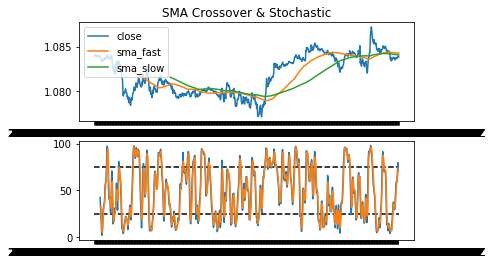

analyzing  GBP_USD


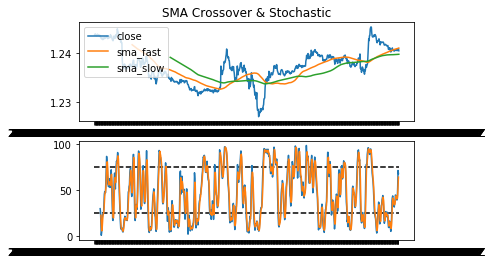

analyzing  USD_CHF


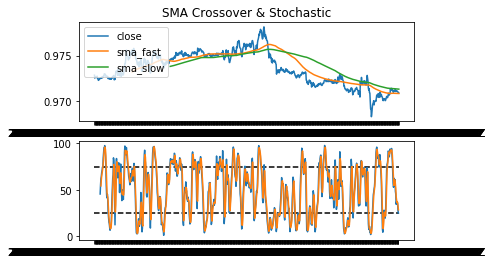

analyzing  AUD_USD


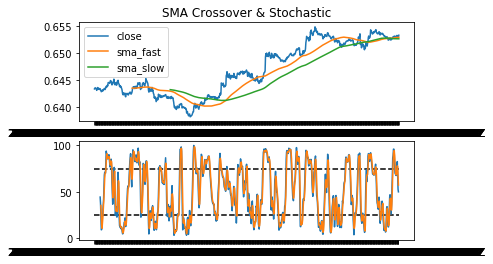

analyzing  USD_CAD


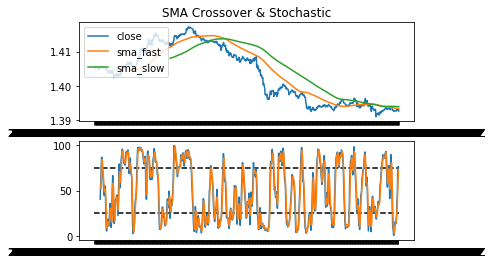

In [20]:
main()

### Codes for continuous execution, preferably run in spyder , not advisable for jupyter notebook

In [ ]:
# Continuous execution        
# starttime=time.time()
# timeout = time.time() + 60*60*1  # 60 seconds times 60 meaning the script will run for 1 hr
# while time.time() <= timeout:
#     try:
#         print("passthrough at ",time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
#         main()
#         time.sleep(300 - ((time.time() - starttime) % 300.0)) # 5 minute interval between each new execution
#     except KeyboardInterrupt:
#         print('\n\nKeyboard exception received. Exiting.')
#         exit()